# Link Analysis

## General idea (transport analogy)

### Transport network

Nodes: stations  
Edges: direct connections  
Hubs: interchanges -> many lines pass through -> network heavily compromised if hubs were removed.

### Property network

Nodes: individual property listings  
Edges: same and similar attributes (same town, same flat type, similar floor area, similar resale price).  
Criteria:
1. Same town  
2. Same flat_type  
3. AND floor area difference ≤ 10 sqm (arbitral threshold)  
4. AND resale price difference ≤ 10% (arbitral threshold)  

Hubs: listings that connect many others -> price benchmarks, popular locations, dominant flat types. Without these hubs, price benchmarking is compromised.

Graph schema: undirected, unweighted graph

In [37]:
# Read dataset
import pandas as pd
import os

ROOT = os.path.abspath("..")

df = pd.read_csv(os.path.join(ROOT, "Data", "HDB", "resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"))

df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='str')

In [38]:
df['town'].unique()

<StringArray>
[     'ANG MO KIO',           'BEDOK',          'BISHAN',     'BUKIT BATOK',
     'BUKIT MERAH',   'BUKIT PANJANG',     'BUKIT TIMAH',    'CENTRAL AREA',
   'CHOA CHU KANG',        'CLEMENTI',         'GEYLANG',         'HOUGANG',
     'JURONG EAST',     'JURONG WEST', 'KALLANG/WHAMPOA',   'MARINE PARADE',
       'PASIR RIS',         'PUNGGOL',      'QUEENSTOWN',       'SEMBAWANG',
        'SENGKANG',       'SERANGOON',        'TAMPINES',       'TOA PAYOH',
       'WOODLANDS',          'YISHUN']
Length: 26, dtype: str

In [39]:
df['flat_type'].unique()

<StringArray>
[          '2 ROOM',           '3 ROOM',           '4 ROOM',
           '5 ROOM',        'EXECUTIVE',           '1 ROOM',
 'MULTI-GENERATION']
Length: 7, dtype: str

## Analysis for Ang mo kio only

In [40]:
import networkx as nx

# Create dataframe containing entries for ANG MO KIO only
df_amk = df[df["town"] == "ANG MO KIO"]

# Initialise graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(df_amk.index)

# Group by flat type only (town already decided)
for _, g in df_amk.groupby("flat_type"):

    # Sort by floor area
    g = g.sort_values("floor_area_sqm")

    idx = g.index.to_list()
    areas = g["floor_area_sqm"].values
    prices = g["resale_price"].values

    n = len(g)

    for i in range(n):
        j = i + 1

        while j < n and areas[j] - areas[i] <= 10:

            # Price similarity
            if abs(prices[j] - prices[i]) / prices[i] <= 0.10:
                G.add_edge(idx[i], idx[j])

            j += 1


In [41]:
# Degree table
deg_df = (
    pd.DataFrame(G.degree(), columns=["node", "degree"])
      .sort_values("degree", ascending=False)
)

# Top 10 hubs
hub_nodes = deg_df.head(10)["node"].tolist()
print(df.loc[hub_nodes].assign(degree=deg_df.set_index("node").loc[hub_nodes]["degree"].values))


         month        town flat_type block        street_name storey_range  \
44933  2019-03  ANG MO KIO    3 ROOM   457  ANG MO KIO AVE 10     04 TO 06   
52448  2019-07  ANG MO KIO    3 ROOM   417  ANG MO KIO AVE 10     04 TO 06   
28246  2018-06  ANG MO KIO    3 ROOM   215   ANG MO KIO AVE 1     04 TO 06   
73018  2020-07  ANG MO KIO    3 ROOM   416  ANG MO KIO AVE 10     01 TO 03   
38807  2018-11  ANG MO KIO    3 ROOM   329   ANG MO KIO AVE 3     01 TO 03   
56501  2019-09  ANG MO KIO    3 ROOM   646   ANG MO KIO AVE 6     01 TO 03   
50606  2019-06  ANG MO KIO    3 ROOM   646   ANG MO KIO AVE 6     01 TO 03   
11527  2017-08  ANG MO KIO    3 ROOM   643   ANG MO KIO AVE 5     07 TO 09   
44954  2019-03  ANG MO KIO    3 ROOM   114   ANG MO KIO AVE 4     07 TO 09   
75482  2020-08  ANG MO KIO    3 ROOM   118   ANG MO KIO AVE 4     07 TO 09   

       floor_area_sqm      flat_model  lease_commence_date  \
44933            75.0  New Generation                 1980   
52448            

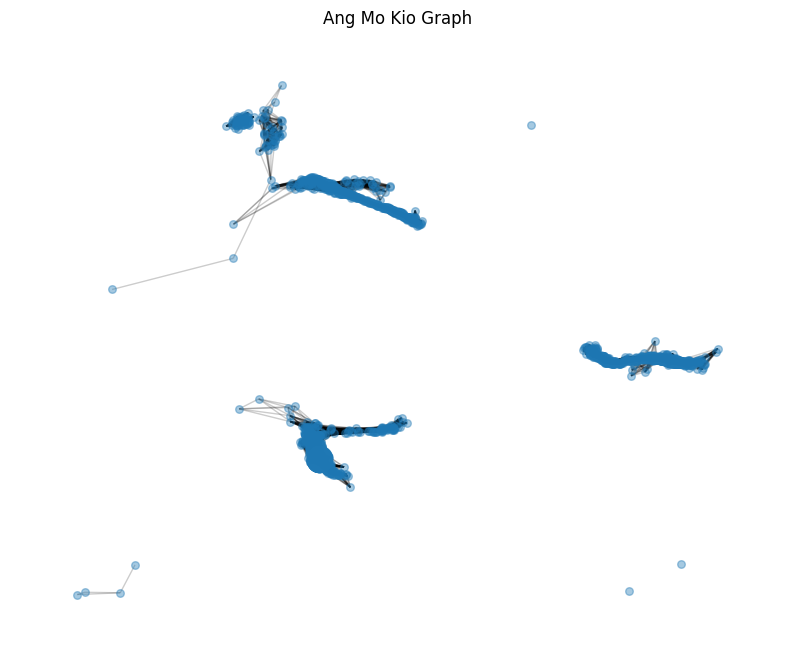

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, seed=42)

# All nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=30,
    alpha=0.4
)

# Hub nodes (bigger)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=hub_nodes,
    node_size=300,
    alpha=0.9
)

# Edges
nx.draw_networkx_edges(
    G, pos,
    alpha=0.2
)

plt.title("Ang Mo Kio Graph")
plt.axis("off")
plt.show()


## Link Analysis Task I

In [43]:
# Create graph for every town
# Loop over each (town, flat_type) group
for _, g in df.groupby(['town', 'flat_type']):

    # Sort listings by floor area
    g = g.sort_values('floor_area_sqm')

    idx = g.index.to_list()
    areas = g['floor_area_sqm'].values
    prices = g['resale_price'].values

    n = len(g)

    # Outer loop: pick a base listing
    for i in range(n):

        # Inner pointer starts from the next listing
        j = i + 1

        # Only compare listings while floor area difference is within 10 sqm
        while j < n and areas[j] - areas[i] <= 10:

            # Check resale price is within 10%
            if abs(prices[j] - prices[i]) / prices[i] <= 0.10:

                # Create an edge if conditions satisifed
                G.add_edge(idx[i], idx[j])

            # Move to the next nearby listing
            j += 1


### High-level analysis of the graph components

In [44]:
# Number of nodes, edges and the density of the graph
print(f"1. Number of listings: {G.number_of_nodes()}")
print(f"2. Number of edges: {G.number_of_edges()}")
density = nx.density(G)
print(f"3. Graph density: {density:.6f}")

1. Number of listings: 80332
2. Number of edges: 19187681
3. Graph density: 0.005947


Graph density is low. This implies that the graph is very sparse.
Most listings don't connect to most other listings.  
Properties are only comparable to a small subset of similar properties.  


In [45]:
# Degree statistics
degrees = [deg for _, deg in G.degree()]
print(f"4. Average connections per listing: {sum(degrees)/len(degrees):.2f}")
print(f"5. Maximum connections: {max(degrees)}")
print(f"6. Minimum connections: {min(degrees)}")

# Listings with highest/lowest degree
node_degrees = dict(G.degree())
max_deg_node = max(node_degrees, key=node_degrees.get)
min_deg_node = min(node_degrees, key=node_degrees.get)
print(f"7. Listing with most connections: Node {max_deg_node} ({node_degrees[max_deg_node]} connections)")
print(f"8. Listing with fewest connections: Node {min_deg_node} ({node_degrees[min_deg_node]} connections)")

4. Average connections per listing: 477.71
5. Maximum connections: 1802
6. Minimum connections: 0
7. Listing with most connections: Node 24102 (1802 connections)
8. Listing with fewest connections: Node 30298 (0 connections)


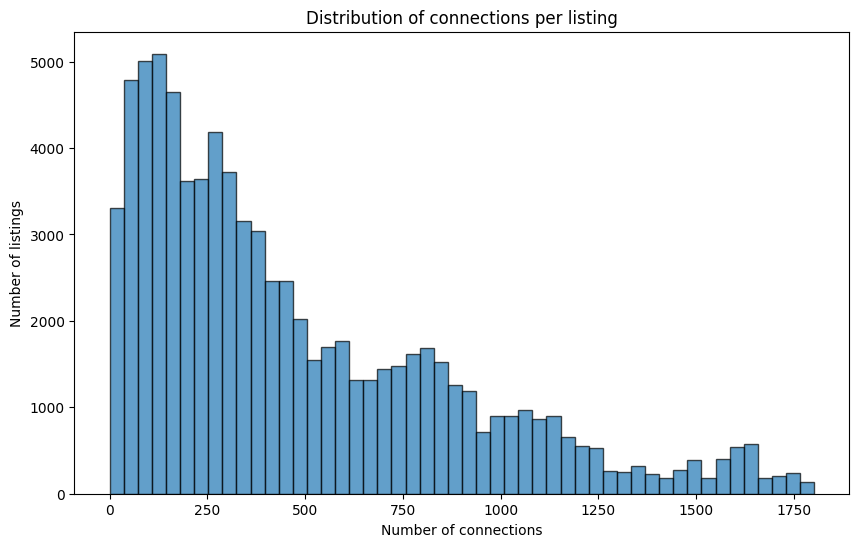

In [46]:
# Degree distribution
import matplotlib.pyplot as plt

degree_counts = {}
for degree in degrees:
    degree_counts[degree] = degree_counts.get(degree, 0) + 1

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of connections')
plt.ylabel('Number of listings')
plt.title('Distribution of connections per listing')
plt.show()

As the graph density is sparse, most listings have no connections. There appears to be a few listings with a large amount of connections (hence the right skewed distribution). 
These listings are operate as "hubs" in their respective towns and flat type, where they help benchmark prices.

## Link Analysis Task II

In [47]:
# High-degree nodes (hubs)
# Degree table
deg_df = (
    pd.DataFrame(G.degree(), columns=["node", "degree"])
      .sort_values("degree", ascending=False)
)

# Top 10 hubs
hub_nodes = deg_df.head(10)["node"].tolist()

hubs_df = (
    df.loc[hub_nodes]
    .assign(degree=deg_df.set_index("node").loc[hub_nodes]["degree"].values)
    .sort_values("degree", ascending=False)
)

hubs_df
# High degree nodes are benchmark listings
# Without these hubs, the price comparison network is fragmented.

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,degree
51832,2019-06,SENGKANG,4 ROOM,408B,FERNVALE RD,16 TO 18,95.0,Premium Apartment,2004,84 years 02 months,415000.0,1802
7367,2017-05,SENGKANG,4 ROOM,443C,FERNVALE RD,04 TO 06,94.0,Model A,2012,94 years 06 months,415000.0,1802
25963,2018-04,SENGKANG,4 ROOM,410C,FERNVALE RD,13 TO 15,95.0,Premium Apartment,2012,93 years 08 months,415000.0,1802
7368,2017-05,SENGKANG,4 ROOM,443C,FERNVALE RD,13 TO 15,94.0,Model A,2012,94 years 06 months,415000.0,1802
74727,2020-07,SENGKANG,4 ROOM,447A,JLN KAYU,16 TO 18,94.0,Model A,2013,92 years 04 months,415000.0,1802
24102,2018-03,SENGKANG,4 ROOM,434B,FERNVALE RD,04 TO 06,94.0,Premium Apartment,2013,94 years 03 months,415000.0,1802
12856,2017-08,SENGKANG,4 ROOM,410C,FERNVALE RD,10 TO 12,95.0,Premium Apartment,2012,94 years 03 months,415000.0,1800
22397,2018-02,SENGKANG,4 ROOM,212C,COMPASSVALE DR,04 TO 06,95.0,Premium Apartment,2012,93 years 08 months,415000.0,1800
22398,2018-02,SENGKANG,4 ROOM,439B,SENGKANG WEST AVE,19 TO 21,94.0,Model A,2011,92 years 01 month,415000.0,1800
31983,2018-07,SENGKANG,4 ROOM,438B,SENGKANG WEST AVE,16 TO 18,94.0,Model A,2011,91 years 08 months,415000.0,1800


In [48]:
# Top hubs of each town
# Degree table
deg_df = pd.DataFrame(G.degree(), columns=["node", "degree"])

# Attach town info
deg_df["town"] = df.loc[deg_df["node"], "town"].values

# Top hub per town
top_hub_per_town = (
    deg_df
    .sort_values(["town", "degree"], ascending=[True, False])
    .groupby("town")
    .head(1)
)

# Full listing details
top_hub_listings = (
    df.loc[top_hub_per_town["node"]]
      .assign(degree=top_hub_per_town["degree"].values)
      .sort_values("degree", ascending = False)
)

top_hub_listings


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,degree
24102,2018-03,SENGKANG,4 ROOM,434B,FERNVALE RD,04 TO 06,94.0,Premium Apartment,2013,94 years 03 months,415000.0,1802
61476,2019-11,PUNGGOL,4 ROOM,672D,EDGEFIELD PLAINS,16 TO 18,90.0,Model A,2015,95 years 02 months,463888.0,1688
21465,2018-01,WOODLANDS,4 ROOM,627,WOODLANDS AVE 6,10 TO 12,96.0,Model A2,1998,79 years 07 months,330000.0,1662
67493,2020-02,TAMPINES,4 ROOM,735,TAMPINES ST 72,07 TO 09,101.0,Model A,1997,76 years 10 months,433000.0,1298
9708,2017-06,YISHUN,4 ROOM,216,YISHUN ST 21,10 TO 12,98.0,New Generation,1985,66 years 09 months,383000.0,1294
13563,2017-09,BEDOK,3 ROOM,54,CHAI CHEE ST,07 TO 09,68.0,New Generation,1981,62 years 08 months,283800.0,1184
42731,2019-01,JURONG WEST,4 ROOM,484,JURONG WEST AVE 1,04 TO 06,100.0,New Generation,1985,65 years 06 months,350000.0,1100
2738,2017-03,CHOA CHU KANG,4 ROOM,471,CHOA CHU KANG AVE 3,13 TO 15,100.0,Model A,1999,80 years 11 months,333000.0,1082
44933,2019-03,ANG MO KIO,3 ROOM,457,ANG MO KIO AVE 10,04 TO 06,75.0,New Generation,1980,59 years 10 months,275000.0,1078
23005,2018-03,BUKIT BATOK,3 ROOM,310,BT BATOK ST 32,01 TO 03,64.0,Simplified,1987,68 years,260000.0,871


In [49]:
# Isolated nodes (these properties have no connections)
isolated_nodes = [n for n, d in G.degree() if d == 0]

# Map isolated nodes back to property records
isolated_df = df.loc[isolated_nodes].copy()

# Sort
isolated_df = isolated_df.sort_values(
    ["town", "flat_type", "resale_price"]
)

isolated_df
# These are the properties that are potentially mispriced.

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
73048,2020-07,ANG MO KIO,3 ROOM,507,ANG MO KIO AVE 8,10 TO 12,67.0,New Generation,1980,59 years,174000.0
30298,2018-07,ANG MO KIO,5 ROOM,644,ANG MO KIO AVE 4,01 TO 03,150.0,Adjoined flat,1980,61 years 05 months,688888.0
70214,2020-05,ANG MO KIO,EXECUTIVE,608,ANG MO KIO AVE 5,04 TO 06,178.0,Adjoined flat,1980,59 years 02 months,1030000.0
